In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.metrics import r2_score
import walnut_utils as wnut
from importlib import reload

In [4]:
iniN = 3
endN = 52
perbasis = 'tree'

src = '../hpcc/traditional/'
dst = '../hpcc/results/trad/'

filename = src + 'qual_quant_' + perbasis + '_summary.csv'
df = pd.read_csv(filename, dtype={1:str})

df = df.drop(index = df[df['PercentKernel'] == -1].index)
df['TipShrivel'] /= 100
df['MinorShrivel'] /= 100
df['MajorShrivel'] /= 100
df['PercentKernel'] /= 100

print(df.shape)

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]

marker = ['o', 'v','*','^', 's', '<', 'X', '>', 'p', '8', 'h', 'H', 'D', 'd', 'P']
#col_wong = ['#e69f00', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']
col_wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40', '#56e495']
col_wong += col_wong

(166, 67)
(67, 2)


In [5]:
df.head()

,UCACCSD,nut_count,tree_count,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_area,...,ShellThickness,PackingTissue,KernelFill,TipShrivel,MinorShrivel,MajorShrivel,Plumpness,EaseOfRemoval,PercentKernel,Blank
0,06-004-4/2008SB_R5_T2,7,3,36.944574,36.082451,33.177452,21832.277099,4.149635,1.132527,6069.174638,...,1.100000,5.000000,5.333333,0.000000,0.074074,0.000000,3.666667,5.000000,0.608687,6.666667
1,06-030-18/2008SB_R8_T10,5,3,37.920928,32.983651,31.577548,18617.977820,4.443319,1.201473,5582.720320,...,1.233333,5.666667,5.666667,0.033333,0.000000,0.000000,5.000000,5.666667,0.461030,0.000000
2,08-019-11/2010SB_R10_T26,9,4,47.113372,38.505577,36.657056,31490.286038,4.637707,1.289331,8019.877077,...,0.950000,4.500000,3.750000,0.027778,0.055556,0.027778,4.750000,4.000000,0.617234,10.000000
3,08-001-28/2010SB_R1_T27,6,2,38.782765,34.380059,32.054447,20571.988995,4.358609,1.209790,5925.350255,...,1.050000,4.500000,4.500000,0.000000,0.050000,0.000000,6.000000,5.000000,0.590367,15.000000
4,08-002-4/2010SB_R2_T24,7,2,38.292884,35.377284,34.434563,22777.117169,4.550625,1.116776,6434.209186,...,1.100000,4.500000,5.500000,0.050000,0.000000,0.000000,5.500000,4.500000,0.598500,0.000000


In [6]:
himalaya = '85-023-2'
interest = df[df.UCACCSD == himalaya]
other = df[df.UCACCSD != himalaya]

In [7]:
for i in range(len(df.columns)):
    print(i,df.columns[i], labels.col_labels[i], labels.col_units[i], sep='\t')

0	UCACCSD	UCACCSD	
1	nut_count	Batch Name	
2	tree_count	Scan Name	
3	nut_length	Nut Length	 [mm]
4	nut_height	Nut Height	 [mm]
5	nut_width	Nut Width	 [mm]
6	nut_vol	Nut Volume	 [mm$^3$]
7	nut_va3d	Nut VA3D	
8	nut_ratio_feret	Nut Feret Ratio	
9	nut_area	Nut Surface Area	 [mm$^2$]
10	nut_sphericity	Nut Sphericity	
11	nut_cnvx_area	Nut Convex Surface Area	 [mm$^2$]
12	nut_cnvx_vol	Nut Convex Volume	 [mm$^3$]
13	nut_ratio_cnvx_area	Nut Ratio Convex Area	 [%]
14	nut_inv_ratio_cnvx_vol	Nut Ratio Convex Volume	 [%]
15	krumbein	Krumbein Index	
16	sneed	Sneed Index	
17	air_vol	Air Volume	 [mm$^3$]
18	meat_vol	Kernel Volume	 [mm$^3$]
19	shell_vol	Shell Volume	 [mm$^3$]
20	vein_vol	Packing Volume	 [mm$^3$]
21	air_ratio_vol	Air Vol Ratio	 [%]
22	meat_ratio_vol	Kernel Vol Ratio	 [%]
23	shell_ratio_vol	Shell Vol Ratio	 [%]
24	vein_ratio_vol	Packing Vol Ratio	 [%]
25	shell_rugosity	Shell Rugosity	
26	shell_thickness	Shell Thickness	 [mm]
27	shell_prot_ratio	Protruding Shell Ratio	 [%]
28	shell_prot_v

In [8]:
offset = 3

qtraits = np.arange(offset,endN)
ptraits = np.arange(endN, len(df.columns))

kcorrstat = np.ones((len(qtraits), len(ptraits)))
kpvalcorr = np.zeros_like(kcorrstat)

scorrstat = np.ones_like(kcorrstat)
spvalcorr = np.zeros_like(kcorrstat)

feats = df.iloc[:, offset:].values.copy()

for i in range(len(qtraits)):
    for j in range(len(ptraits)):
        kstat, kpval = stats.kendalltau(feats[:,qtraits[i] - offset], feats[:,ptraits[j] - offset])
        sstat, spval = stats.spearmanr(feats[:,qtraits[i] - offset], feats[:,ptraits[j] - offset])
        
        kcorrstat[i,j] = kstat
        kpvalcorr[i,j] = kpval
        
        scorrstat[i,j] = sstat
        spvalcorr[i,j] = spval

In [9]:
corr = scorrstat.copy()
print(corr.shape)

(49, 15)


In [10]:
fs = 22
for yidx in ptraits:
    fig, ax = plt.subplots(2,4,figsize=(20,9), sharey=True)
    ax = np.atleast_1d(ax).ravel()

    y = df.iloc[:, yidx].values

    ax[0].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs);
    ax[4].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs);

    for i,xidx in enumerate(np.argsort(np.abs(corr[:, yidx-len(qtraits)-offset]))[::-1][:len(ax)] + offset):
        x = df.iloc[:, xidx].values

        xrange = np.linspace(np.min(x)-0.1, np.max(x)+0.1, 100)

        s = corr[xidx - offset, yidx - len(qtraits) - offset]
        ax[i].scatter(x,y, c='b', alpha=0.25, s=75)
        #ax[i].set_aspect('equal', 'datalim')
        ax[i].tick_params(labelsize=fs-2)

        ax[i].set_xlabel(labels.col_labels[xidx] + labels.col_units[xidx], fontsize=fs);

        new_series = P.Polynomial.fit(x,y, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(y, new_series(x))
        axlabel = 'R$^2$ = {:.2}\ns   = {:.2}'.format(r2,s)
        ax[i].plot(xrange, new_series(xrange), color='r', label=axlabel, ls='-.', lw=3)
        #ax.plot(xrange, xrange, color='k', label=axlabel, ls='-.', lw=3)

        ax[i].legend(loc='lower right', fontsize=fs)
    
    fig.suptitle(labels.col_labels[yidx] + ' [averaged by '+perbasis+']', fontsize=fs+3)
    fig.tight_layout()
    filename = dst + 'highest_corrs_' + labels.col_labels[yidx].replace(' ', '_').lower() + '_per_'+perbasis+'_2x4'
    print(filename)
    
    plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close()

../hpcc/results/trad/highest_corrs_shell_integrity_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_texture_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_color_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_seal_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_strength_per_tree_2x4
../hpcc/results/trad/highest_corrs_shell_thickness_per_tree_2x4
../hpcc/results/trad/highest_corrs_packing_tissue_per_tree_2x4
../hpcc/results/trad/highest_corrs_kernel_fill_per_tree_2x4
../hpcc/results/trad/highest_corrs_tip_shrivel_per_tree_2x4
../hpcc/results/trad/highest_corrs_minor_shrivel_per_tree_2x4
../hpcc/results/trad/highest_corrs_major_shrivel_per_tree_2x4
../hpcc/results/trad/highest_corrs_plumpness_per_tree_2x4
../hpcc/results/trad/highest_corrs_ease_of_removal_per_tree_2x4
../hpcc/results/trad/highest_corrs_kernel_weight_ratio_per_tree_2x4
../hpcc/results/trad/highest_corrs_blank_per_tree_2x4


In [11]:
fs = 19
for yidx in ptraits:
    fig, ax = plt.subplots(1,5,figsize=(20,5), sharey=True)
    ax = np.atleast_1d(ax).ravel()
    y = df.iloc[:, yidx].values

    ax[0].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs+4);
    #ax[4].set_ylabel(labels.col_labels[yidx] + labels.col_units[yidx], fontsize=fs);

    for i,xidx in enumerate(np.argsort(np.abs(corr[:, yidx-len(qtraits)-offset]))[::-1][:len(ax)] + offset):
        x = df.iloc[:, xidx].values

        xrange = np.linspace(np.min(x)-0.1, np.max(x)+0.1, 100)

        s = corr[xidx - offset, yidx - len(qtraits) - offset]
        ax[i].scatter(x,y, c='b', alpha=0.25, s=75)
        ax[i].tick_params(labelsize=fs-2)

        ax[i].set_xlabel(labels.col_labels[xidx] + labels.col_units[xidx], fontsize=fs);

        new_series = P.Polynomial.fit(x,y, deg=1, full=False)
        foo = new_series.convert().coef
        r2 = r2_score(y, new_series(x))
        axlabel = 'R$^2$ = {:.2}\ns   = {:.2}'.format(r2,s)
        ax[i].plot(xrange, new_series(xrange), color='r', label=axlabel, ls='-.', lw=3)
        ax[i].legend(loc='lower right', fontsize=fs)
    
    fig.suptitle(labels.col_labels[yidx] + ' [averaged by '+perbasis+']', fontsize=fs+3)
    fig.tight_layout()
    filename = dst + 'highest_corrs_' + labels.col_labels[yidx].replace(' ', '_').lower() + '_per_'+perbasis+'_1x5'
    print(filename)
    
    plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close()

../hpcc/results/trad/highest_corrs_shell_integrity_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_texture_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_color_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_seal_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_strength_per_tree_1x5
../hpcc/results/trad/highest_corrs_shell_thickness_per_tree_1x5
../hpcc/results/trad/highest_corrs_packing_tissue_per_tree_1x5
../hpcc/results/trad/highest_corrs_kernel_fill_per_tree_1x5
../hpcc/results/trad/highest_corrs_tip_shrivel_per_tree_1x5
../hpcc/results/trad/highest_corrs_minor_shrivel_per_tree_1x5
../hpcc/results/trad/highest_corrs_major_shrivel_per_tree_1x5
../hpcc/results/trad/highest_corrs_plumpness_per_tree_1x5
../hpcc/results/trad/highest_corrs_ease_of_removal_per_tree_1x5
../hpcc/results/trad/highest_corrs_kernel_weight_ratio_per_tree_1x5
../hpcc/results/trad/highest_corrs_blank_per_tree_1x5


../hpcc/results/trad/qual_vs_quant_correlation_coeff_v_per_tree


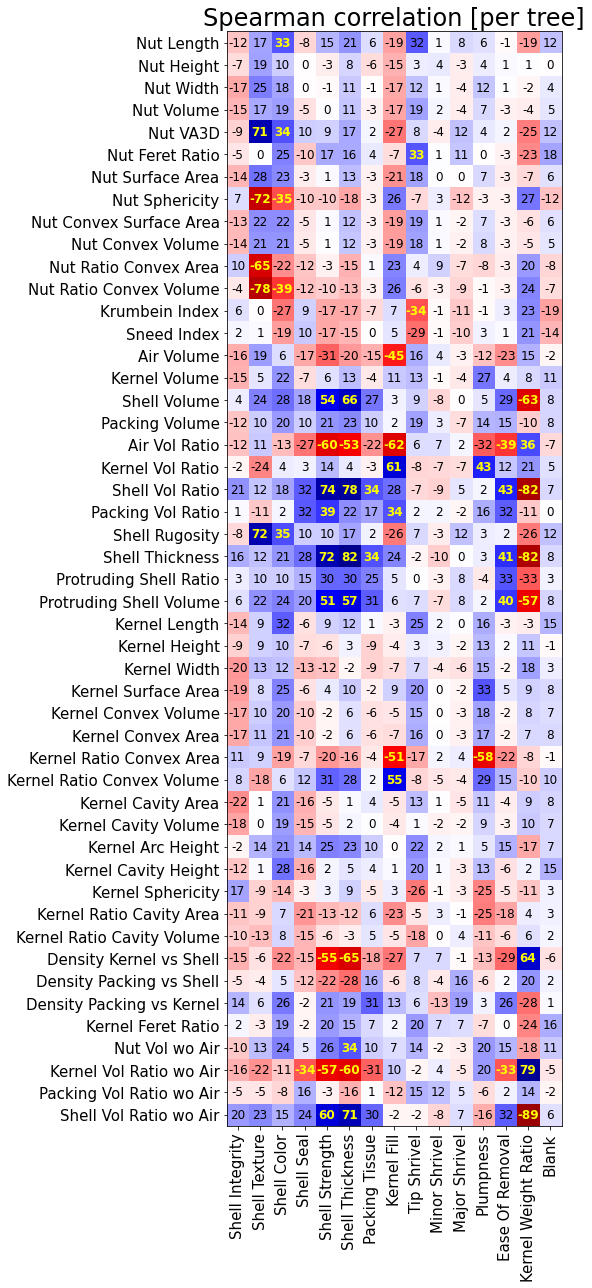

In [12]:
fig, ax = plt.subplots(figsize=(18,18))
im = ax.imshow(corr, cmap='seismic_r', vmin=-1, vmax=1)

# We want to show all ticks...
ax.set_xticks(np.arange(corr.shape[1]))
ax.set_yticks(np.arange(corr.shape[0]))
              
# ... and label them with the respective list entries
ax.set_xticklabels(labels.col_labels.iloc[ptraits])
ax.set_yticklabels(labels.col_labels.iloc[qtraits])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va ='center',
         rotation_mode="anchor")

ax.tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
            fw = 'bold'
            fs = 14
        else:
            tcolor = 'black'
            fw = 'normal'
            fs = 12
        text = ax.text(j, i, '{:d}'.format(int(np.round(100*corr[i,j]))),
                       ha="center", va="center", color=tcolor, fontsize=12, fontweight=fw)

ax.set_title("Spearman correlation [per "+perbasis+"]", fontsize=24)
#fig.colorbar(im, ax=ax, pad=0.01, shrink=0.5)
fig.tight_layout()

filename = dst + 'qual_vs_quant_correlation_coeff_v_per_' + perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=100, format='pdf', bbox_inches='tight')

../hpcc/results/trad/qual_vs_quant_correlation_coefficients_h_per_tree


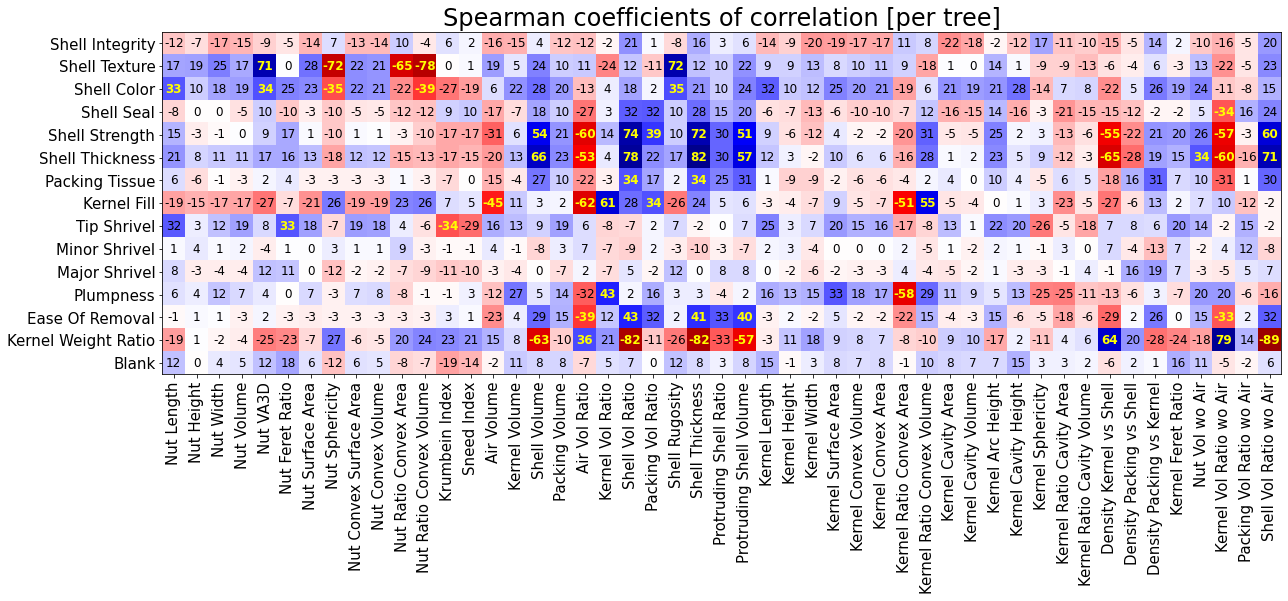

In [13]:
fig, ax = plt.subplots(figsize=(18,18))
im = ax.imshow(corr.T, cmap='seismic_r', vmin=-1, vmax=1)

# We want to show all ticks...
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticks(np.arange(corr.shape[0]))
              
# ... and label them with the respective list entries
ax.set_yticklabels(labels.col_labels.iloc[ptraits])
ax.set_xticklabels(labels.col_labels.iloc[qtraits])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va ='center',
         rotation_mode="anchor")

ax.tick_params(labelsize=15)

# Loop over data dimensions and create text annotations.
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
            fw = 'bold'
            fs = 14
        else:
            tcolor = 'black'
            fw = 'normal'
            fs = 12
        text = ax.text(i,j, '{:d}'.format(int(np.round(100*corr[i,j]))),
                       ha="center", va="center", color=tcolor, fontsize=12, fontweight=fw)

ax.set_title("Spearman coefficients of correlation [per "+perbasis+"]", fontsize=24)
#fig.colorbar(im, ax=ax, pad=0.01, shrink=0.5)
fig.tight_layout()

filename = dst + 'qual_vs_quant_correlation_coefficients_h_per_' + perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=100, format='pdf', bbox_inches='tight')

# Limited Correlation

In [14]:
offset = 3
qtraits = np.array([21,22,23,24] + [49,51,50] + [65])
ptraits = qtraits.copy()
filename = src + 'vol_ratios_spearman_correlation_pvals_'+perbasis+'.csv' 

if os.path.isfile(filename):
    
    foo = np.loadtxt(filename, delimiter=',')
    scorrstat = foo[:len(qtraits)]
    spvalcorr = foo[len(qtraits):]
    
else:
    import resampling

    scorrstat = np.ones((len(qtraits), len(ptraits)))
    spvalcorr = np.zeros_like(scorrstat)

    feats = df.iloc[:, offset:].values.copy()

    for i in range(len(qtraits)):
        for j in range(i):
            x = feats[:,qtraits[i] - offset]
            y = feats[:,ptraits[j] - offset]
            if len(y) < 500:
                def statistic(x):  # permute only `x`
                    return stats.spearmanr(x, y).correlation
                sstat, spval = stats.spearmanr(x,y)

                spval = resampling.permutation_test((x,), statistic, permutation_type='pairings')

                scorrstat[i,j] = sstat
                spvalcorr[i,j] = spval.pvalue

    np.savetxt(filename, np.vstack((scorrstat, spvalcorr)), delimiter=',')

In [15]:
corr = scorrstat.copy()
pval = spvalcorr.copy()

for i in range(corr.shape[0]-1):
    for j in range(i+1,corr.shape[1]):
        corr[i,j] = 0
        pval[i,j] = 1
corr.shape

pval_ = np.zeros_like(pval).astype(int)
for i in range(pval.shape[0]):
    for j in range(pval.shape[1]):
        if (pval[i,j] == 0) or (pval[i,j] > 1e-2):
            pval_[i,j] = 0
        elif (pval[i,j] <= 1e-2) and (pval[i,j] > 1e-3):
            pval_[i,j] = 1
        elif (pval[i,j] <= 1e-3) and (pval[i,j] > 1e-4):
            pval_[i,j] = 2
        else:
            pval_[i,j] = 3
pval_

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 0, 0, 0],
       [0, 2, 2, 2, 0, 0, 0, 0],
       [2, 1, 2, 0, 2, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 0, 0],
       [2, 1, 2, 0, 2, 2, 0, 0]])

../hpcc/results/trad/vol_ratios_correlation_tree


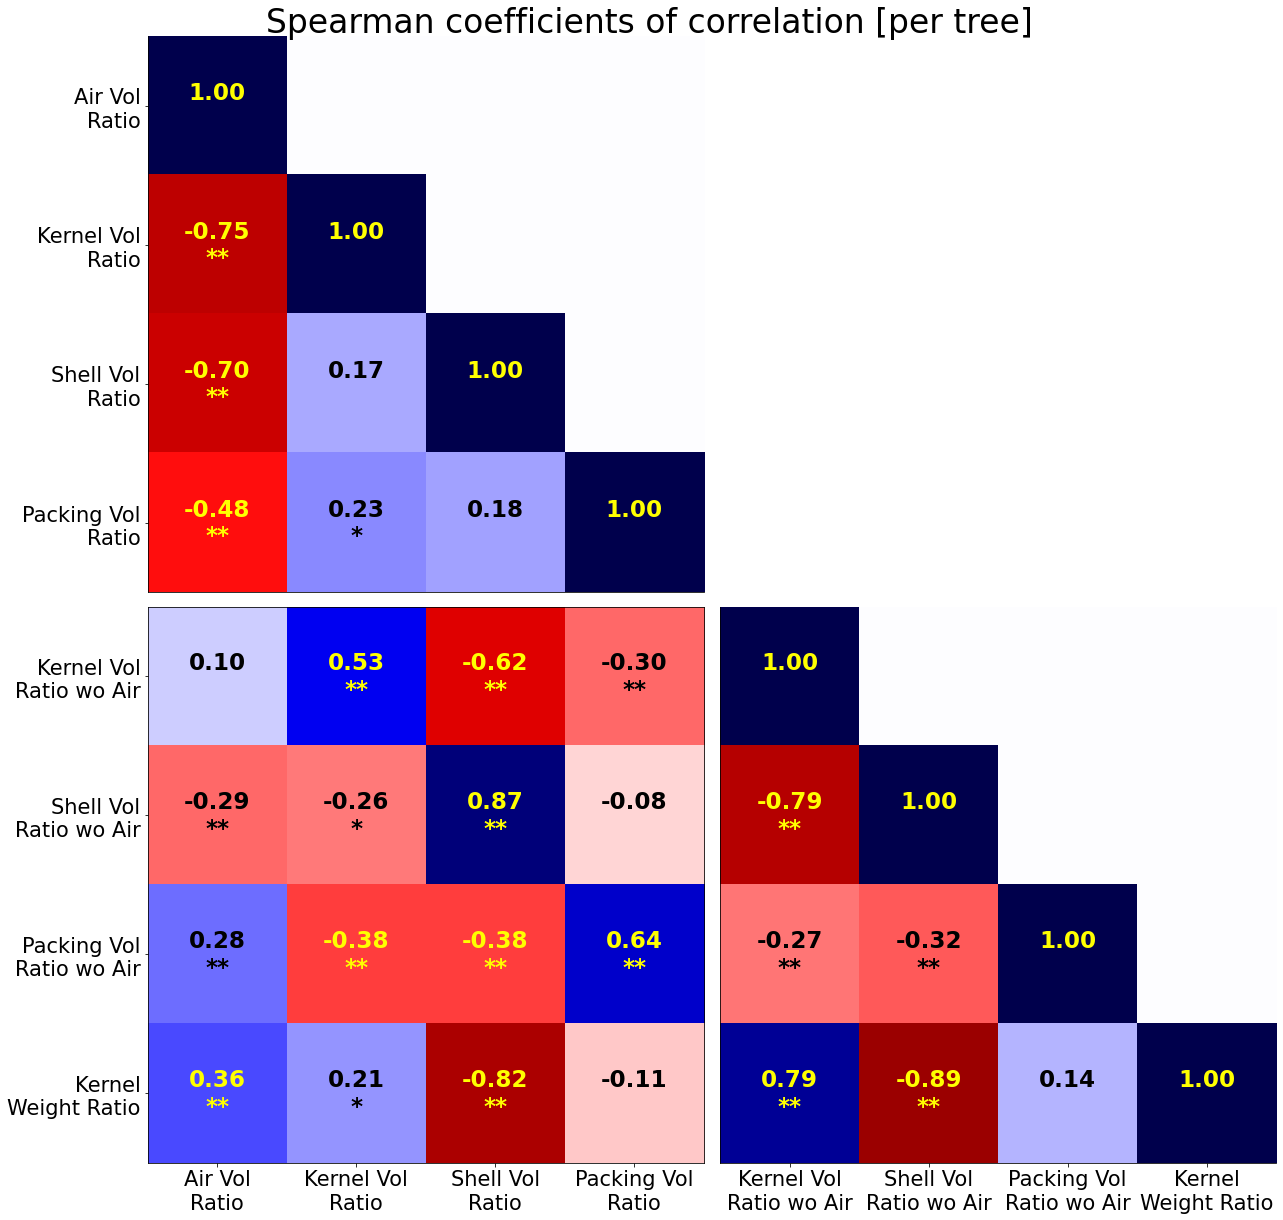

In [16]:
fs = 23
tw = 12
pt = 0.
fw = 'bold'
sig = ['', '*', '**', '***']
fig, ax = plt.subplots(2,2,figsize=(18,17.25))
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(corr[:4,:4], cmap='seismic_r', vmin=-1, vmax=1)
ax[2].imshow(corr[4:, :4], cmap='seismic_r', vmin=-1, vmax=1)
ax[3].imshow(corr[4:, 4:], cmap='seismic_r', vmin=-1, vmax=1)

for i in range(len(ax)):
    ax[i].set_xticks(np.arange(4))
    ax[i].set_yticks(np.arange(4))
    ax[i].tick_params(labelsize=fs-2)

ax[0].set_yticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][:4]])
ax[2].set_yticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][4:]])

ax[2].set_xticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][:4]])
ax[3].set_xticklabels([textwrap.fill(x,tw) for x in labels.col_labels.iloc[qtraits][4:]])

ax[0].get_xaxis().set_ticks([])
ax[3].get_yaxis().set_ticks([])

for i in [0,3]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

for i in range(4):
    for j in range(i+1):
        if np.abs(corr[i,j]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[0].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i,j],2)), sig[pval_[i,j]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
for i in range(4):
    for j in range(4):
        if np.abs(corr[i+4,j]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[2].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i+4,j],2)), sig[pval_[i+4,j]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)

for i in range(4):
    for j in range(i+1):
        if np.abs(corr[i+4,j+4]) > 0.33:
            tcolor = 'yellow'
        else:
            tcolor = 'black'
        text = ax[3].text(j, i-pt, '{:.2f}\n{}'.format((np.round(corr[i+4,j+4],2)), sig[pval_[i+4,j+4]]),
                       ha="center", va="center", color=tcolor, fontsize=fs, fontweight=fw)
        
fig.delaxes(ax[1])

fig.suptitle("Spearman coefficients of correlation [per "+perbasis+"]", fontsize=fs+10)

fig.tight_layout()

filename = dst + 'vol_ratios_correlation_' +perbasis
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', dpi=100, format='pdf', bbox_inches='tight')

# Linear models

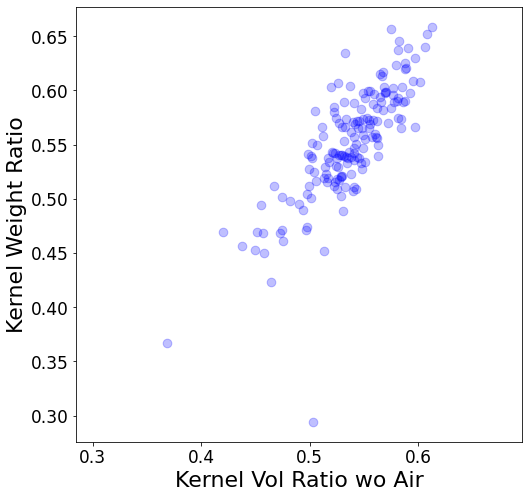

In [17]:
fs = 22

yidx = 65
xidx = 49

x = df.iloc[:, xidx].values
y = df.iloc[:, yidx].values

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(x,y, c='b', alpha=0.25, s=75)
ax.set_aspect('equal', 'datalim')
ax.tick_params(labelsize=fs-5)

ax.set_xlabel(labels.col_labels[xidx], fontsize=fs);
ax.set_ylabel(labels.col_labels[yidx], fontsize=fs);



# Regression

In [ ]:
fixtrait = 27
mask = list(range(2,fixtrait)) + list(range(fixtrait,51))
X = df.iloc[:,mask].values
print(X.shape)
y = df.iloc[:,fixtrait].values
print(y.shape)

In [ ]:
alphas = np.sort(np.hstack((10**np.linspace(-4,0,5), 5*10**np.linspace(-4,-1,4))))
clf = linear.RidgeCV(alphas=alphas).fit(X,y)
clf.score(X,y)

In [ ]:
clf.alpha_